## data generation as before just change the channel 1 instead of 3

us shape normalize vanda agadi: (10000, 1024)
us shape normalize vanda pachi: (10000, 1024)
us shape reshape vanda pachi: (10000, 32, 32, 1)
Saving training data to u_train.npy...
Saving grid points to grid.npy...
Saving grid points to grid.npy...
Time to save the data: 0.08 seconds
Data saving completed!
sample data = (32, 32)


C:\Users\Manju\AppData\Local\Temp\ipykernel_19224\1902617415.py:248: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(sample, labels = 10, cmap='viridis')


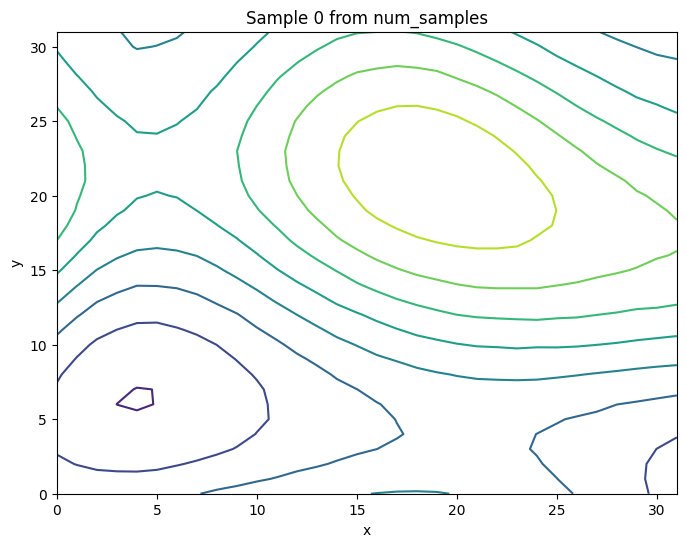

In [4]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2)) # aply the kernel function, wich gives the smoothness of te function
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'generating data {i+1} started out of {n_samples}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale) # covariance matric is computed, which is used to generate the data, and its gives the relation between the points
        jitter = 1e-5
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        # eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)
        # print(f'generating data {i+1} done out of {n_samples}')


    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance
        print(f'us shape normalize vanda agadi: {us.shape}')

        us = normalize(us)
        print(f'us shape normalize vanda pachi: {us.shape}')
        us = us.reshape(-1, self.n_grid, self.n_grid, 1)  # Reshape to (n_samples, n_grid, n_grid, 1)
        print(f'us shape reshape vanda pachi: {us.shape}')



        # print(f"Generated {n_samples} samples with shape: {us.shape}")


        # Now create RGB data for each sample, using np.random.rand for each channel
        # Here we create random RGB values for each sample (you can adjust this as needed)
        # us_rgb = np.random.rand(n_samples, self.n_grid, self.n_grid, 1)  # RGB values for color images

        # key = random.PRNGKey(42)  # Initialize PRNG key
        # key, subkey = random.split(key)  # Split key to create subkey


       
            # Example: combining some part of 'us' for each channel
        # us_rgb[..., 0] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Red
        # us_rgb[..., 1] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Green
        # us_rgb[..., 2] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Blue


        return X, us

        # return X, us


# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 32  # Number of grid points per dimension
    length_scale_list = [0.1, 0.5, 1.0, 2.0]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 10000 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data_local_32_10k.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid.npy"), np.array(data.x))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")




    # # Specify the directory where you want to save the data
    # save_dir = './data_generation/'

    # # Ensure the directory exists, create it if not
    # os.makedirs(save_dir, exist_ok=True)

    # # Save the data with the full path to the specific folder
    # np.save(os.path.join(save_dir, "u_train_dg.npy"), np.array(data.u_train))
    # np.save(os.path.join(save_dir, "u_test_dg.npy"), np.array(data.u_test))



# # Save the training and testing data
# np.save("u_train_dg.npy", np.array(data.u_train))
# np.save("u_test_dg.npy", np.array(data.u_test))

# # # Save the grid points (optional, if you want to reconstruct spatial locations)
# np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
print(f'sample data = {sample.shape}')
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
# plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.contour(sample, labels = 10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## This cell for the generated data to check data are different or not

In [5]:
import numpy as np

train_data = np.load("./data_generation_checking/phasefield_data_local_32_10k.npy")
# train_data = train_data[:,:,:,:1]  # Extract only the first channel
print(f"Training data shape: {train_data.shape}")

# Check if all images are identical
if np.all(train_data == train_data[0]):
    print("All training samples are identical!")
else:
    print("Training samples are different.")

Training data shape: (10000, 32, 32, 1)
Training samples are different.


## This cell for checking genereated data correct or not and jetter 1e-3 and large length scale

us shape normalize vanda agadi: (500, 1024)
us shape normalize vanda pachi: (500, 1024)
us shape reshape vanda pachi: (500, 32, 32, 1)
shape of the x: (1024, 2)
Saving training data to u_train.npy...
Saving grid points to grid.npy...
Saving grid points to grid.npy...
Time to save the data: 0.01 seconds
Data saving completed!
Min value after normalization: -1.0
Max value after normalization: 1.0
sample data = (32, 32)


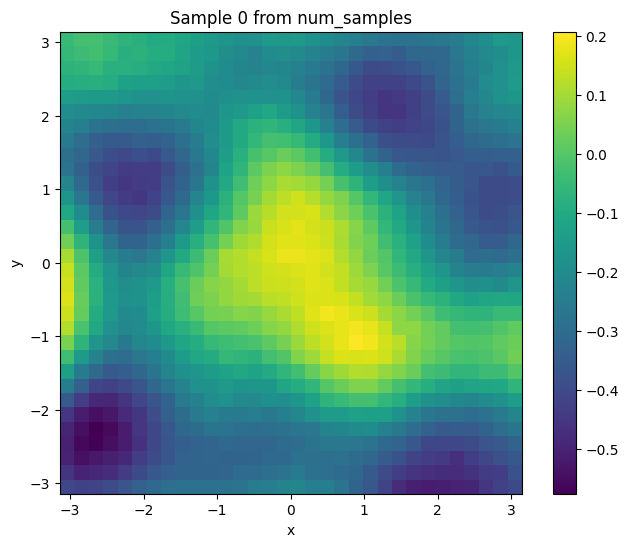

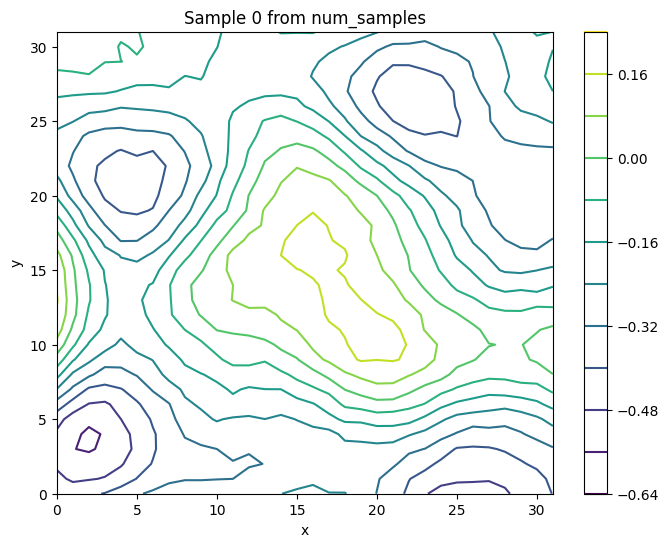

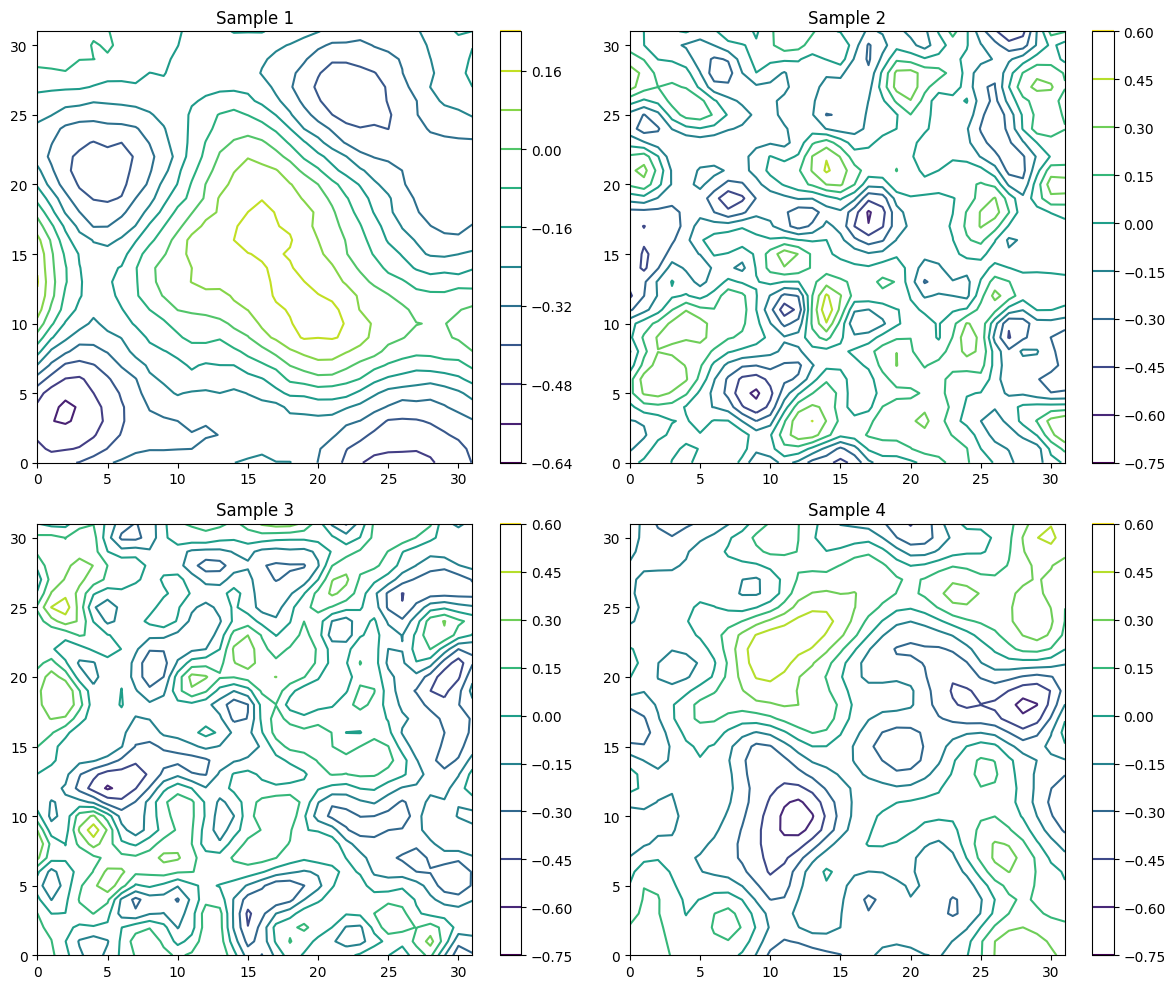

Loaded data shape: (500, 32, 32, 1)
Grid shape: (1024, 2)
Mean of samples: -0.033105943
Std of samples: 0.20830989


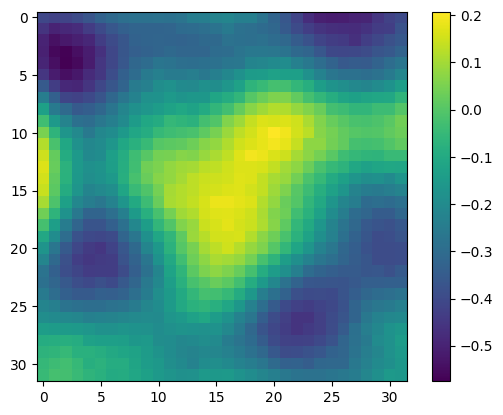

In [7]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2)) # aply the kernel function, wich gives the smoothness of te function
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'generating data {i+1} started out of {n_samples}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale) # covariance matric is computed, which is used to generate the data, and its gives the relation between the points
        jitter = 1e-3 # this is used to make the matrix positive definite
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))
        # if i == 10:
        #     print("Covariance matrix shape:", cov.shape)
        #     break

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)
        # print(f'generating data {i+1} done out of {n_samples}')


    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1

   


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance
        print(f'us shape normalize vanda agadi: {us.shape}')

        us = normalize(us)
        print(f'us shape normalize vanda pachi: {us.shape}')
        us = us.reshape(-1, self.n_grid, self.n_grid)  # Reshape to (n_samples, n_grid, n_grid, 1)
        us = jnp.expand_dims(us, axis=-1)
        print(f'us shape reshape vanda pachi: {us.shape}')
        print(f'shape of the x: {X.shape}')

        return X, us



# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 32  # Number of grid points per dimension
    length_scale_list = [0.15, 0.3, 0.5, 0.8, 1.0]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 500 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data_local_32_500.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid.npy"), np.array(data.X))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    # np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")


    print("Min value after normalization:", np.min(data.num_samples))
    print("Max value after normalization:", np.max(data.num_samples))




   


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
print(f'sample data = {sample.shape}')
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
# plt.contour(sample, levels=10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.figure(figsize=(8, 6))
# plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.contour(sample, levels=10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot multiple samples in a grid
n_plots = 4  # Number of samples to display
plt.figure(figsize=(12, 10))
for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    sample = data.num_samples[i, :, :, 0]
    # plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    # plt.contour(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    plt.contour(sample, levels=10, cmap='viridis')
    plt.colorbar()
    plt.title(f"Sample {i+1}")
plt.tight_layout()
plt.show()


loaded_data = np.load(os.path.join(save_dir, "phasefield_data_local_32_500.npy"))
print("Loaded data shape:", loaded_data.shape)  # Expected: (num_samples, 32, 32, 1)
grid = np.load(os.path.join(save_dir, "grid.npy"))
print("Grid shape:", grid.shape)  # Expected: (32*32, 2)


print("Mean of samples:", np.mean(loaded_data))
print("Std of samples:", np.std(loaded_data))


loaded_samples = np.load("./data_generation_checking/phasefield_data_local_32_500.npy")
plt.imshow(loaded_samples[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

## here jitter+ 1e-4 and medium length scale

us shape normalize vanda agadi: (1000, 1024)
us shape normalize vanda pachi: (1000, 1024)
us shape reshape vanda pachi: (1000, 32, 32, 1)
shape of the x: (1024, 2)
Saving training data to u_train.npy...
Saving grid points to grid.npy...
Saving grid points to grid.npy...
Time to save the data: 0.01 seconds
Data saving completed!
Min value after normalization: -1.0
Max value after normalization: 1.0
sample data = (32, 32)


C:\Users\Manju\AppData\Local\Temp\ipykernel_16340\2920242838.py:214: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(sample, labels = 10, cmap='viridis')


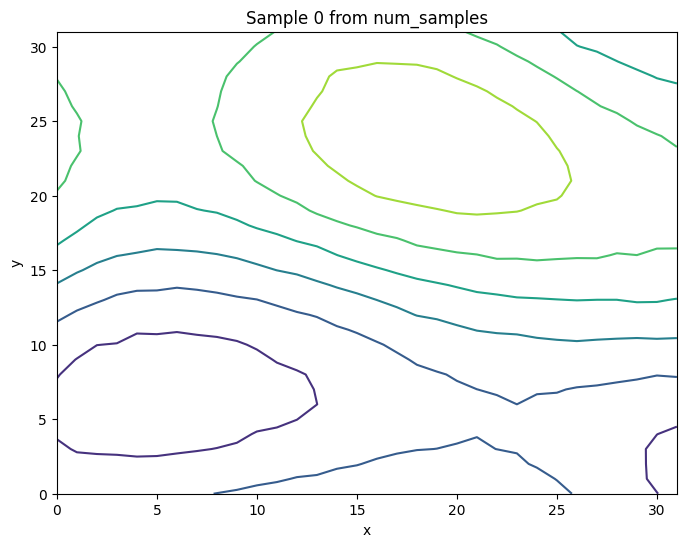

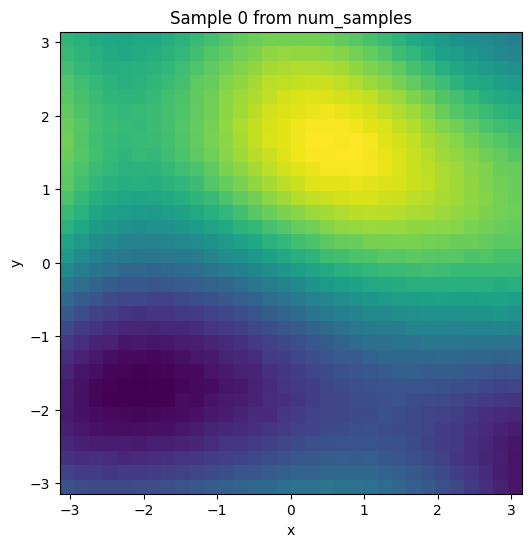

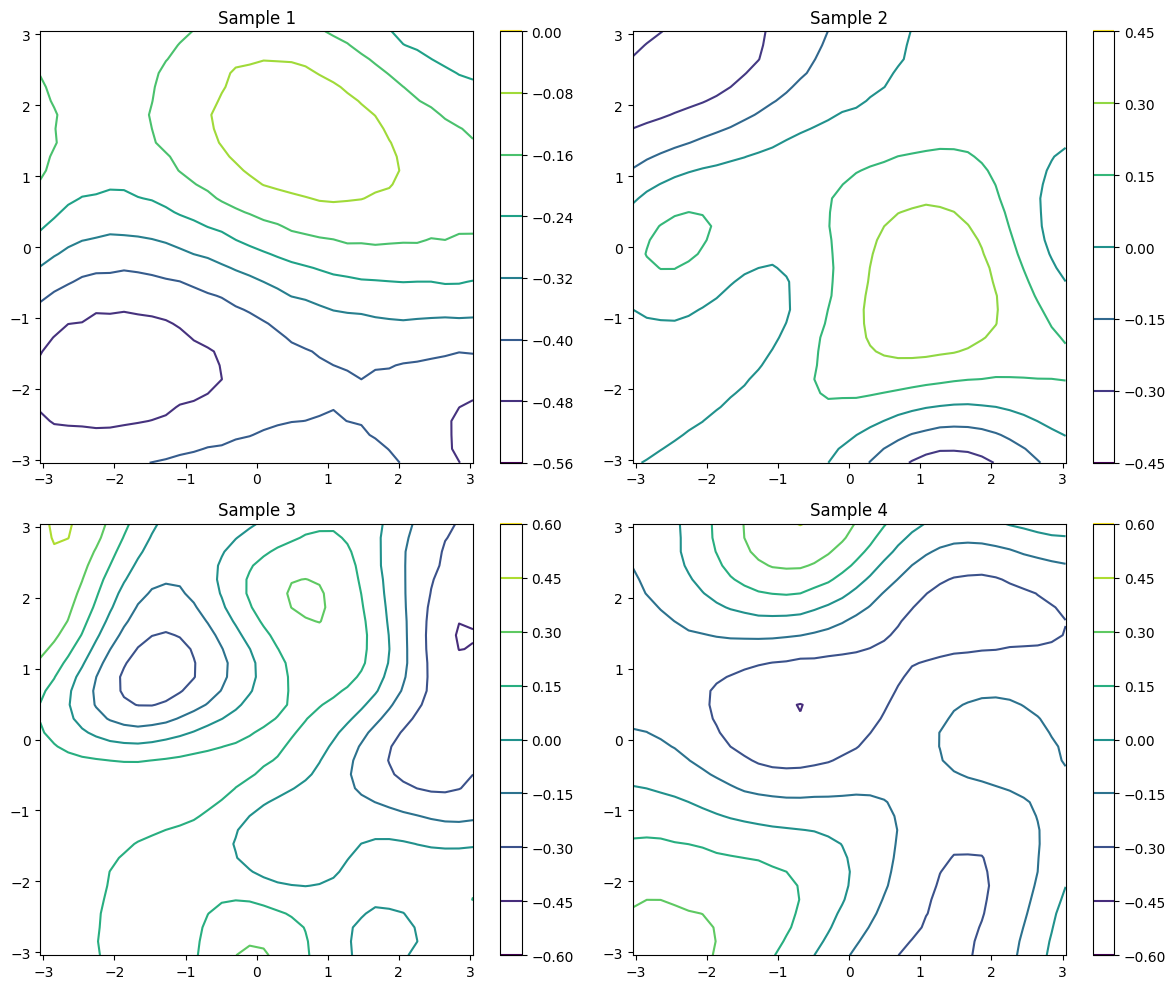

Loaded data shape: (1000, 32, 32, 1)
Grid shape: (1024, 2)
Mean of samples: 0.0014940934
Std of samples: 0.22784443


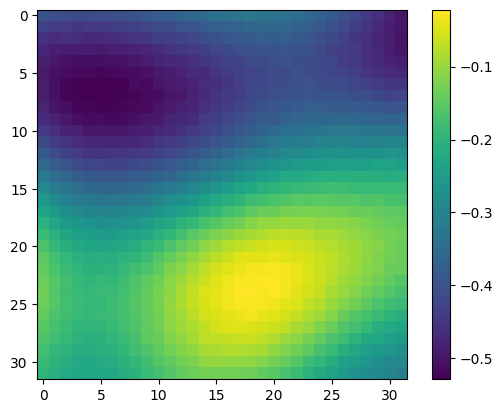

In [4]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2)) # aply the kernel function, wich gives the smoothness of te function
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'generating data {i+1} started out of {n_samples}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale) # covariance matric is computed, which is used to generate the data, and its gives the relation between the points
        jitter = 1e-4 # this is used to make the matrix positive definite
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))
        
            

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)
        # print(f'generating data {i+1} done out of {n_samples}')


    return grid_points, jnp.array(samples)





def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1

   


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1000):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance
        print(f'us shape normalize vanda agadi: {us.shape}')

        us = normalize(us)
        print(f'us shape normalize vanda pachi: {us.shape}')
        us = us.reshape(-1, self.n_grid, self.n_grid)  # Reshape to (n_samples, n_grid, n_grid, 1)
        us = jnp.expand_dims(us, axis=-1)
        print(f'us shape reshape vanda pachi: {us.shape}')
        print(f'shape of the x: {X.shape}')

        return X, us

       


# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 32  # Number of grid points per dimension
    length_scale_list = [1.0, 1.5, 2.0, 2.5]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 1000 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data_local_32_1000.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid.npy"), np.array(data.X))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    # np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")


    print("Min value after normalization:", np.min(data.num_samples))
    print("Max value after normalization:", np.max(data.num_samples))



# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
print(f'sample data = {sample.shape}')
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
# plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.contour(sample, labels = 10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
# plt.contour(sample, labels = 10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot multiple samples in a grid
n_plots = 4  # Number of samples to display
plt.figure(figsize=(12, 10))
for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    sample = data.num_samples[i, :, :, 0]
    # plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    plt.contour(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(f"Sample {i+1}")
plt.tight_layout()
plt.show()


loaded_data = np.load("./data_generation_checking/phasefield_data_local_32_1000.npy")
print("Loaded data shape:", loaded_data.shape)  # Expected: (num_samples, 32, 32, 1)
grid = np.load(os.path.join(save_dir, "grid.npy"))
print("Grid shape:", grid.shape)  # Expected: (32*32, 2)


print("Mean of samples:", np.mean(loaded_data))
print("Std of samples:", np.std(loaded_data))

# plt all sample together
loaded_samples = np.load("./data_generation_checking/phasefield_data_local_32_1000.npy")
plt.imshow(loaded_samples[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

## Here length scale decresed and see the result

Covariance matrix eigenvalues min: 5.0710478e-05 max: 369.46243
Covariance matrix eigenvalues min: 9.7997494e-05 max: 36.40215
Covariance matrix eigenvalues min: 0.0018747967 max: 6.065324
Covariance matrix eigenvalues min: 9.7997494e-05 max: 36.40215
Covariance matrix eigenvalues min: 8.751675e-05 max: 129.28291
Covariance matrix eigenvalues min: 0.0018747967 max: 6.065324
Covariance matrix eigenvalues min: 5.0710478e-05 max: 369.46243
Covariance matrix eigenvalues min: 5.0710478e-05 max: 369.46243
Covariance matrix eigenvalues min: 8.751675e-05 max: 129.28291
Covariance matrix eigenvalues min: 9.7997494e-05 max: 36.40215
us shape normalize vanda agadi: (10, 1024)
us shape normalize vanda pachi: (10, 1024)
us shape reshape vanda pachi: (10, 32, 32, 1)
shape of the x: (1024, 2)
Saving training data to u_train.npy...
Saving grid points to grid.npy...
Saving grid points to grid.npy...
Time to save the data: 0.00 seconds
Data saving completed!
Min value after normalization: -1.0
Max value

C:\Users\Manju\AppData\Local\Temp\ipykernel_8248\2472177183.py:220: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(sample, labels = 5, cmap='viridis')


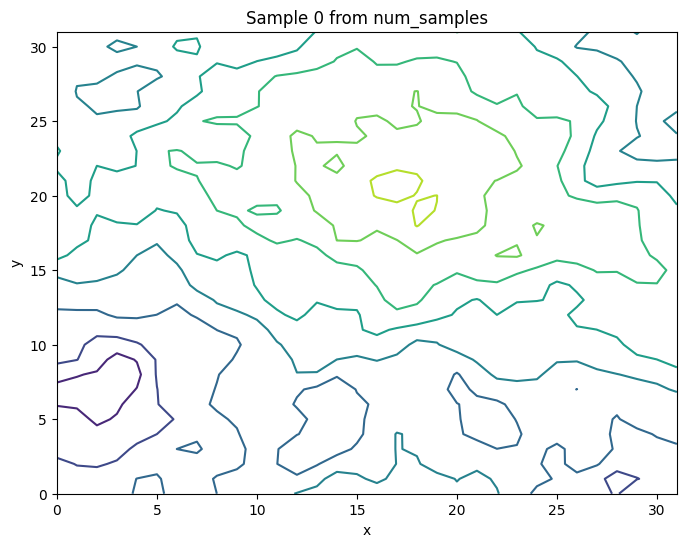

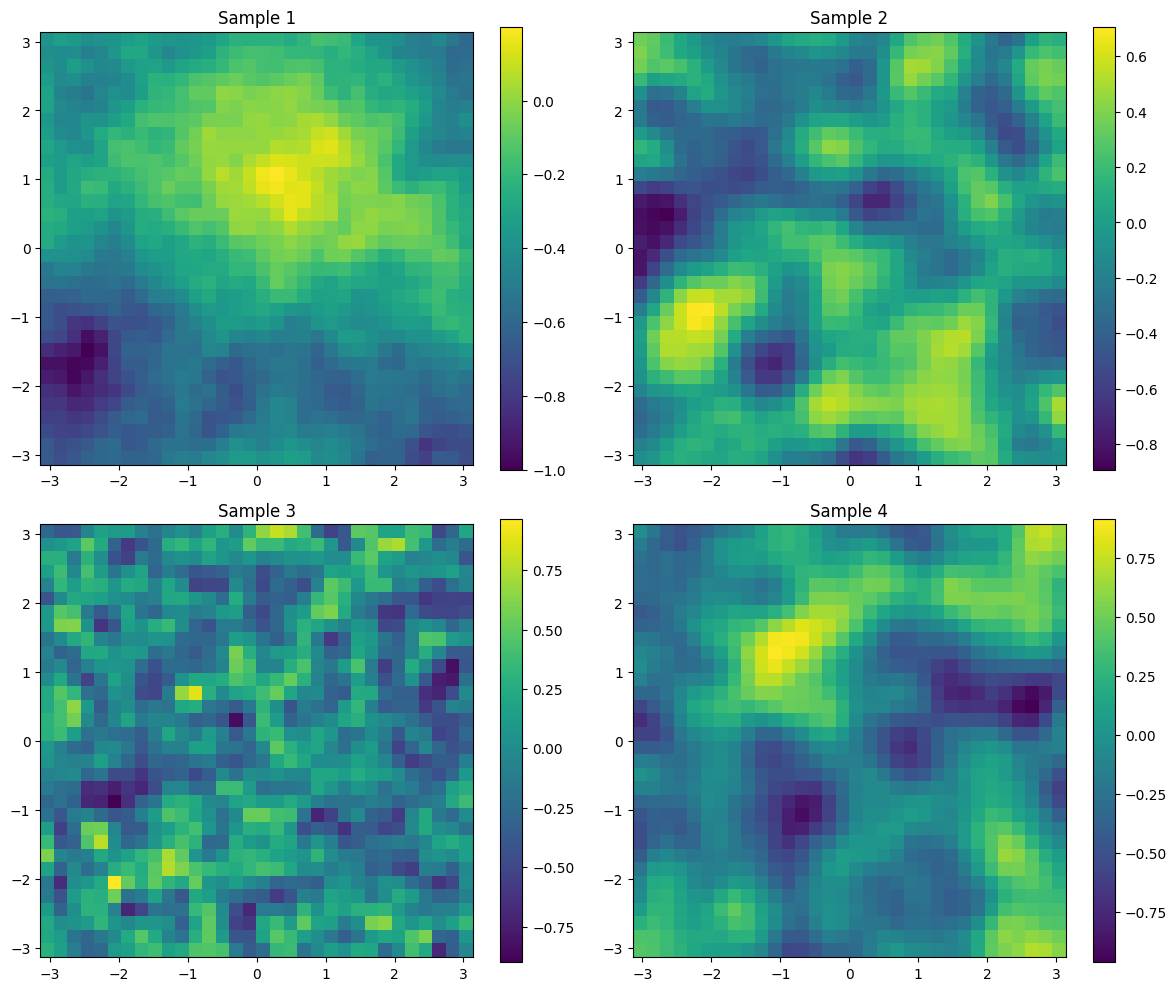

Loaded data shape: (10, 32, 32, 1)
Grid shape: (1024, 2)
Mean of samples: -0.010823817
Std of samples: 0.33277938


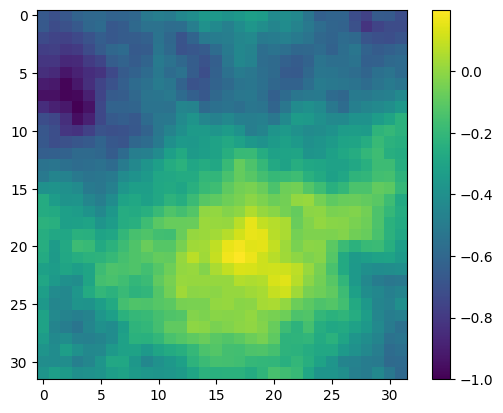

In [48]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2)) # aply the kernel function, wich gives the smoothness of te function
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'generating data {i+1} started out of {n_samples}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale) # covariance matric is computed, which is used to generate the data, and its gives the relation between the points
        jitter = 1e-4 # this is used to make the matrix positive definite
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)
        # print(f'generating data {i+1} done out of {n_samples}')


    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1

   


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance
        print(f'us shape normalize vanda agadi: {us.shape}')

        us = normalize(us)
        print(f'us shape normalize vanda pachi: {us.shape}')
        us = us.reshape(-1, self.n_grid, self.n_grid)  # Reshape to (n_samples, n_grid, n_grid, 1)
        us = jnp.expand_dims(us, axis=-1)
        print(f'us shape reshape vanda pachi: {us.shape}')
        print(f'shape of the x: {X.shape}')

        return X, us # X is the grid point and us is the sample data 

    


# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 32  # Number of grid points per dimension
    length_scale_list = [0.2, 0.5, 1.0, 2.0]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 10 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data_local_32_10.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid.npy"), np.array(data.X))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    # np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")


    print("Min value after normalization:", np.min(data.num_samples))
    print("Max value after normalization:", np.max(data.num_samples))




    
# np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
print(f'sample data = {sample.shape}')
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
# plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.contour(sample, labels = 5, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot multiple samples in a grid
n_plots = 4  # Number of samples to display
plt.figure(figsize=(12, 10))
for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    sample = data.num_samples[i, :, :, 0]
    plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(f"Sample {i+1}")
plt.tight_layout()
plt.show()


loaded_data = np.load(os.path.join(save_dir, "phasefield_data_local_32_10.npy"))
print("Loaded data shape:", loaded_data.shape)  # Expected: (num_samples, 32, 32, 1)
grid = np.load(os.path.join(save_dir, "grid.npy"))
print("Grid shape:", grid.shape)  # Expected: (32*32, 2)


print("Mean of samples:", np.mean(loaded_data))
print("Std of samples:", np.std(loaded_data))


loaded_samples = np.load("./data_generation_checking/phasefield_data_local_32_10.npy")
plt.imshow(loaded_samples[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

## training the data 

Training data shape: (10000, 28, 28, 1)
pp2 shape: (28, 28), qq2 shape: (28, 28)


  0%|          | 0/20 [00:00<?, ?it/s]

input_fno ko shape after reshape inside operator net.(1, 28, 28, 1)
o ko shape after apply.(1, 28, 28, 1)
[u_nn ko shape on loss single : (28, 28, 1)
uk ko shape as input:(28, 28, 1)
pp2 shape after expanding: (1, 28, 28, 1)
Shape of predictions: (28, 28, 1)
Shape of y (ground truth): (28, 28, 1)


c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 500/500 [00:08<00:00, 56.93it/s, Batch=500, Loss=0.0023270303] 


Input Condition Statistics:
Min: -1.0, Max: 1.0
Model Prediction Statistics:
Min: -0.531390905380249, Max: 0.5926284193992615
plt train ko size (28, 28, 1)


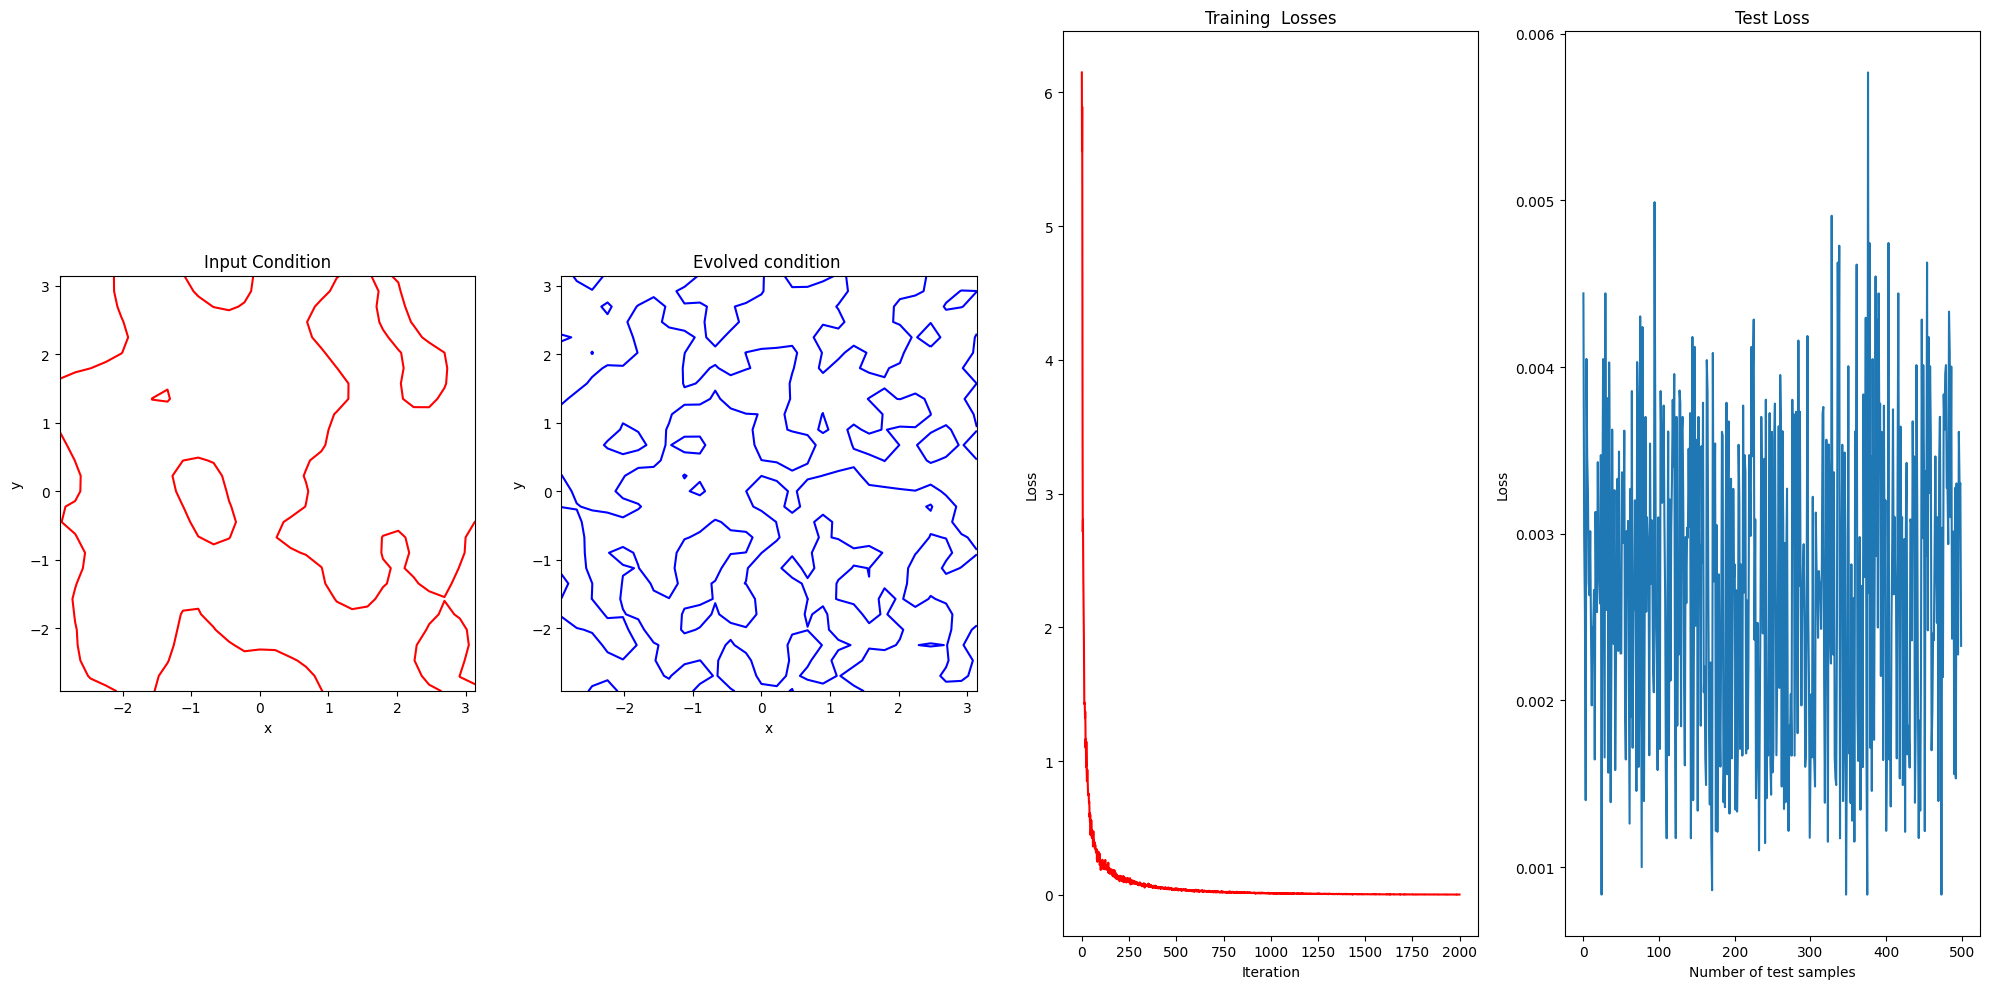

In [11]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))


class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=20, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u  # Input samples
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key
        self.current_idx = 0  # Track the current index for iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    def __len__(self):
        'Return the number of batches'
        return self.N // self.batch_size  # Total full batches

    def __iter__(self):
        'Return an iterator that resets itself'
        self.current_idx = 0  # Reset the index
        return self

    def __next__(self):
        'Get the next batch'
        if self.current_idx >= len(self):  # Stop when all batches are processed
            raise StopIteration
        self.current_idx += 1
        return self.__getitem__(self.current_idx)

    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx, :]
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)


        # Logging losses
        self.train_losses = []
        # self.total_energy_loss_log = []
        self.test_losses = []  # Initialize list to track test losses



        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        self.itercount = iter(range(50000))


    
        
     

    # @jax.jit
    def normalize(self,data):
        min_val = jnp.min(data, axis=(0, 1))
        max_val = jnp.max(data, axis=(0, 1))
        range_val = max_val - min_val
        range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
        normalized_data = 2 * (data - min_val) / range_val - 1
        return normalized_data

    
    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            # print(f'uk ko shape before reshape inside operator net.{uk.shape}')
        #    uk = uk.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape input 
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
            print(f'input_fno ko shape after reshape inside operator net.{input_FNO.shape}')


            O = self.N_apply(params, input_FNO)  # Apply the FNO network
            print(f'o ko shape after apply.{O.shape}')

        #    O = jnp.real(O)  # Take the real part of the output
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            # print(f'o ko shape after reshape.{O.shape}')


            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            # O = O / self.norm_par  # Normalize the output
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    def allen_cahn_equation(self, uk, total_steps=500):
        # debug.print("Processing x")  # Prints each x correctly
        print(f'uk ko shape as input:{uk.shape}')

            # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        print(f'pp2 shape after expanding: {self.pp2.shape}')  # Expected: (1, 128, 128, 1)


        # # Broadcast pp2 and qq2 to match the shape of uk
        # self.pp2 = jnp.broadcast_to(self.pp2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        # self.qq2 = jnp.broadcast_to(self.qq2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        # print(f'pp2 shape after broadcasting: {self.pp2.shape}')  # Expected: (1, 128, 128, 3)

        # for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)
        # print(f'uk ko shape as input:{uk.shape}')

        # Check shapes for debugging
        # print(f"pp2 shape after broadcasting: {self.pp2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"qq2 shape after broadcasting: {self.qq2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128, 3)
        # print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)
        uk = uk.reshape(self.N, self.N, 1)

        

        return jnp.real(uk) # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # print(f'[uk ko shape on loss single : {uk.shape}')

        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)
        print(f'[u_nn ko shape on loss single : {u_nn.shape}')

        u_ac = self.allen_cahn_equation(uk)

        print("Shape of predictions:", u_nn.shape)
        print("Shape of y (ground truth):", u_ac.shape)

        
        # Allen-Cahn equation loss
        # energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        # total_loss = datadriven_loss + energy_loss
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
        # print(f' batch ko size : {batch.shape}')
        # batch losses
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        # debug.print(f'size of batch loss after vmap={batch_loss.shape}')  # Prints each x correctly

        batch_loss  = jnp.mean(batch_loss)
        
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        # print(f'uk ko shape before step:{uk.shape}')
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of the SPiFOL class
    def train(self, data_train, num_epochs=1):
        # print(f'data_train ko shape:{data_train[0].shape}')
        # Example training loop
        pbar = trange(num_epochs)
        for it in pbar:
            for batch_idx, batch in enumerate(data_train):
                self.opt_state = self.step(batch_idx, self.opt_state, batch)
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                self.train_losses.append(loss)
                pbar.set_postfix({ 'Epoch': it+1, 'Batch': batch_idx+1, 'Loss': jnp.real(loss)})

    def test(self, data_test):
        """Evaluate model performance on test data without updating parameters."""

        pbar = trange(len(data_test))
        params = self.get_params(self.opt_state)  # Fetch current model parameters


        for it in pbar:
            loss = self.loss_batches(params, data_test[it])
            self.test_losses.append(loss)
            pbar.set_postfix({'Batch': it+1, 'Loss': jnp.real(loss)})
           

    
                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid


x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


# theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation_checking/phasefield_data_28x28_Onet_10k.npy')
print(f"Training data shape: {input_condition.shape}")
# input_condition = input_condition[:2000]
# batch_size = 32  # Choose an appropriate batch size
# num_batches = input_condition.shape[0] // batch_size



# Inspect the data
# print(input_condition)
# print(type(input_condition)) 


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
print(f'pp2 shape: {pp2.shape}, qq2 shape: {qq2.shape}')



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]



cahn = eps**2
# Generate the data trainig samples
data_train = DataGenerator(input_condition[:1000], batch_size=10)
# print(f'data_train shape: {data_train[0].shape}, Total Batches: {len(data_train)}')
data_test = DataGenerator(input_condition[1000:1500], batch_size = 1)

# for i, x in enumerate(data_train):
# print(len(data_train))  # Should return 100 for 2000 samples and batch size 20.





for arch in arch_list:
#    # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
#     # final_state = model.allen_cahn_equation(input_condition)
#     # In your main code:
   
    model.train(data_train, num_epochs=20)
    # batch_size = 64  # Example batch size
    # model.train(input_condition, batch_size=batch_size, nIter=10)

    model.test(data_test)


params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, data_test[0][0])


print("Input Condition Statistics:")
print(f"Min: {jnp.min(input_condition)}, Max: {jnp.max(input_condition)}")
print("Model Prediction Statistics:")
print(f"Min: {jnp.min(model_prediction)}, Max: {jnp.max(model_prediction)}")



# Plot the initial and final states
fig, axs = plt.subplots(1, 4, figsize=(20, 10))


# input condition plot
plt_train = jnp.real(data_test[0][0])
print(f'plt train ko size {plt_train.shape}')
plt_train = plt_train[:,:,0]
plt_pred = jnp.real(model_prediction)
plt_pred = plt_pred[:,:,0]

# plot input condition
# axs[0].imshow(input_condition)
axs[0].contour(x, y,plt_train , levels=[0], colors="red")
# axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")

axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# plot evolved condition
axs[1].contour(x, y, plt_pred, levels=[0], colors="blue")
# axs[1].imshow(model_prediction)
axs[1].set_title('Evolved condition ')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')



# plot training loss 
axs[2].plot(model.train_losses, color='red')
# axs[2].plot(model.test_losses, color ='blue')  # Use the test_losses list from your model
axs[2].set_title('Training  Losses')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Loss')
# axs[2].legend(['Training Loss', 'Test Loss'])

# Plot Test Loss
axs[3].plot(model.test_losses)  # Use the test_losses list from your model
axs[3].set_title('Test Loss')
axs[3].set_xlabel('Number of test samples')
axs[3].set_ylabel('Loss')


plt.tight_layout() 
plt.show()

            

## new code copy from data generation code for trianing the data 

Training data shape: (10000, 28, 28, 1)
pp2 shape: (28, 28), qq2 shape: (28, 28)


  0%|          | 0/10 [00:00<?, ?it/s]

uk ko shape before reshape inside operator net.(28, 28, 1)
input_fno ko shape after reshape .(1, 28, 28, 1)
Calling self.N_apply now...
self.N_apply executed successfully!
o ko shape after reshape.(28, 28, 1)
Shape of predictions (u_nn): (28, 28, 1)
uk ko shape as input:(28, 28, 1)
pp2 shape after expanding: (1, 28, 28, 1)
uk size after allen cahn (28, 28, 1)
Shape of predictions: (28, 28, 1)
Shape of y (ground truth): (28, 28, 1)


c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 500/500 [00:03<00:00, 132.52it/s, Batch=500, Loss=0.0046485146]


Input Condition Statistics:
Min: -1.0, Max: 1.0
Model Prediction Statistics:
Min: -0.6390517950057983, Max: 0.5522175431251526


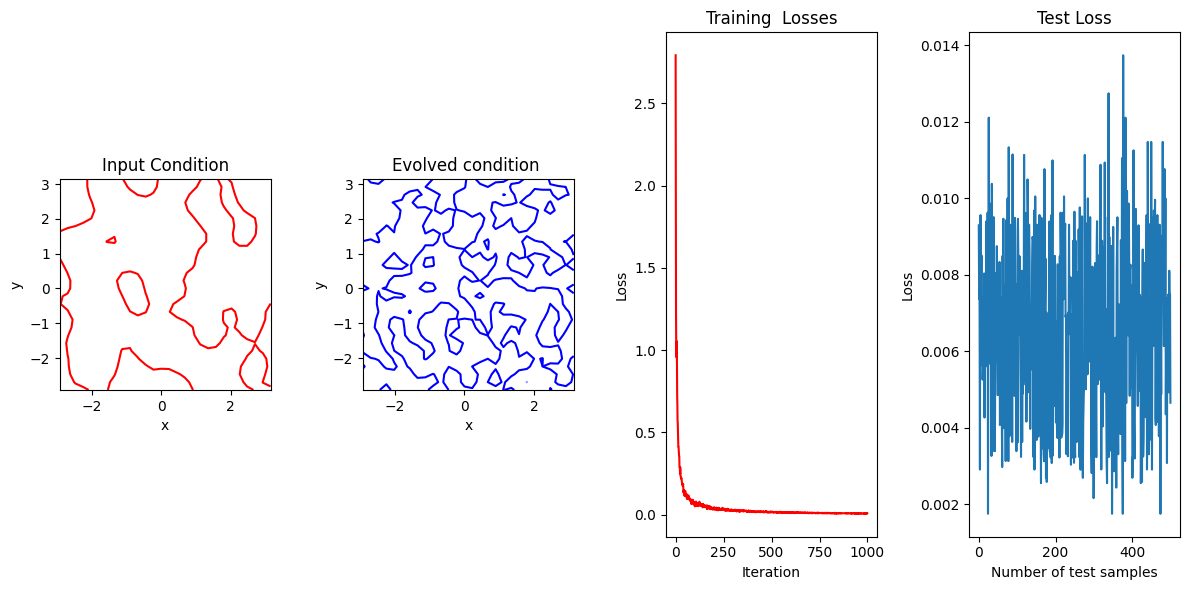

In [ ]:
from haiku import Flatten
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
import tensorflow as tf
from tensorflow.keras import layers
from jax.nn import relu, tanh







def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))


class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=20, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u  # Input samples
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key
        self.current_idx = 0  # Track the current index for iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    def __len__(self):
        'Return the number of batches'
        return self.N // self.batch_size  # Total full batches

    def __iter__(self):
        'Return an iterator that resets itself'
        self.current_idx = 0  # Reset the index
        return self

    def __next__(self):
        'Get the next batch'
        if self.current_idx >= len(self):  # Stop when all batches are processed
            raise StopIteration
        self.current_idx += 1
        return self.__getitem__(self.current_idx)

    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx, :]
        return u



class SPiFOL:
    def __init__( self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        
       

        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y

      


    
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)


        # Logging losses
        self.train_losses = []
        # self.total_energy_loss_log = []
        self.test_losses = []  # Initialize list to track test losses



        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        self.itercount = iter(range(50000))


    # @jax.jit
    def normalize(self,data):
        min_val = jnp.min(data, axis=(0, 1))
        max_val = jnp.max(data, axis=(0, 1))
        range_val = max_val - min_val
        range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
        normalized_data = 2 * (data - min_val) / range_val - 1
        return normalized_data

    
    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            print(f'uk ko shape before reshape inside operator net.{uk.shape}')
        #    uk = uk.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape input 
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
            print(f'input_fno ko shape after reshape .{input_FNO.shape}')

            
            print("Calling self.N_apply now...")

            O = self.N_apply(params, input_FNO)  # Apply the FNO network
            print("self.N_apply executed successfully!")

        #    O = jnp.real(O)  # Take the real part of the output
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            print(f'o ko shape after reshape.{O.shape}')


            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            # O = O / self.norm_par  # Normalize the output
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    def allen_cahn_equation(self, uk, total_steps=500):
        # debug.print("Processing x")  # Prints each x correctly
        print(f'uk ko shape as input:{uk.shape}')

            # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        print(f'pp2 shape after expanding: {self.pp2.shape}')  # Expected: (1, 128, 128, 1)


        # # Broadcast pp2 and qq2 to match the shape of uk
        # self.pp2 = jnp.broadcast_to(self.pp2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        # self.qq2 = jnp.broadcast_to(self.qq2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        # print(f'pp2 shape after broadcasting: {self.pp2.shape}')  # Expected: (1, 128, 128, 3)

        # for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)
        # print(f'uk ko shape as input:{uk.shape}')

        # Check shapes for debugging
        # print(f"pp2 shape after broadcasting: {self.pp2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"qq2 shape after broadcasting: {self.qq2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128, 3)
        # print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)
        uk = uk.reshape(self.N, self.N, 1)
        print(f'uk size after allen cahn {uk.shape}')

        

        return jnp.real(uk) # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # print(f'[uk ko shape on loss single : {uk.shape}')

        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)
        # print(f'[u_nn ko shape on loss single : {u_nn.shape}')
        print(f'Shape of predictions (u_nn): {u_nn.shape}')
       


        u_ac = self.allen_cahn_equation(uk)

        print("Shape of predictions:", u_nn.shape)
        print("Shape of y (ground truth):", u_ac.shape)

        
        # Allen-Cahn equation loss
        # energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        # total_loss = datadriven_loss + energy_loss
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
        # print(f' batch ko size : {batch.shape}')
        # batch losses
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        # debug.print(f'size of batch loss after vmap={batch_loss.shape}')  # Prints each x correctly

        batch_loss  = jnp.mean(batch_loss)
        
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        # print(f'uk ko shape before step:{uk.shape}')
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of the SPiFOL class
    def train(self, data_train, num_epochs=1):
        # print(f'data_train ko shape:{data_train[0].shape}')
        # Example training loop
        pbar = trange(num_epochs)
        for it in pbar:
            for batch_idx, batch in enumerate(data_train):
                self.opt_state = self.step(batch_idx, self.opt_state, batch)
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                self.train_losses.append(loss)
                pbar.set_postfix({ 'Epoch': it+1, 'Batch': batch_idx+1, 'Loss': jnp.real(loss)})

    def test(self, data_test):
        """Evaluate model performance on test data without updating parameters."""

        pbar = trange(len(data_test))
        params = self.get_params(self.opt_state)  # Fetch current model parameters


        for it in pbar:
            loss = self.loss_batches(params, data_test[it])
            self.test_losses.append(loss)
            pbar.set_postfix({'Batch': it+1, 'Loss': jnp.real(loss)})
           


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid


x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


# theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation_checking/phasefield_data_28x28_Onet_10k.npy')
print(f"Training data shape: {input_condition.shape}")

 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
print(f'pp2 shape: {pp2.shape}, qq2 shape: {qq2.shape}')



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]

# Define FNO layers
fno_layers = [
   Dense(33),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]


cahn = eps**2
# Generate the data trainig samples
data_train = DataGenerator(input_condition[:1000], batch_size=10)
# print(f'data_train shape: {data_train[0].shape, Total Batches: {len(data_train)}')
data_test = DataGenerator(input_condition[1000:1500], batch_size=1)


for arch in arch_list:
#    # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers, lr, arch)
#     # final_state = model.allen_cahn_equation(input_condition)
#     # In your main code:
   
    model.train(data_train, num_epochs=10)
    # batch_size = 64  # Example batch size
    # model.train(input_condition, batch_size=batch_size, nIter=10)

    model.test(data_test)


params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, data_test[0][0])


print("Input Condition Statistics:")
print(f"Min: {jnp.min(input_condition)}, Max: {jnp.max(input_condition)}")
print("Model Prediction Statistics:")
print(f"Min: {jnp.min(model_prediction)}, Max: {jnp.max(model_prediction)}")



# Plot the initial and final states
fig, axs = plt.subplots(1, 4, figsize=(12,6))


# input condition plot
plt_train = jnp.real(data_test[0][0])
plt_train = plt_train[:,:,0]
plt_pred = jnp.real(model_prediction)
plt_pred = plt_pred[:,:,0]

# plot input condition
# axs[0].imshow(input_condition)
axs[0].contour(x, y,plt_train , levels=[0], colors="red")
# axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")

axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# plot evolved condition
axs[1].contour(x, y, plt_pred, levels=[0], colors="blue")
# axs[1].imshow(model_prediction)
axs[1].set_title('Evolved condition ')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')



# plot training loss 
axs[2].plot(model.train_losses, color='red')
# axs[2].plot(model.test_losses, color ='blue')  # Use the test_losses list from your model
axs[2].set_title('Training  Losses')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Loss')
# axs[2].legend(['Training Loss', 'Test Loss'])

# Plot Test Loss
axs[3].plot(model.test_losses)  # Use the test_losses list from your model
axs[3].set_title('Test Loss')
axs[3].set_xlabel('Number of test samples')
axs[3].set_ylabel('Loss')


plt.tight_layout() 
plt.show()

            

## numerical simulation to check the data are good or not 

Training data shape: (10000, 28, 28, 1)


<Figure size 640x480 with 0 Axes>

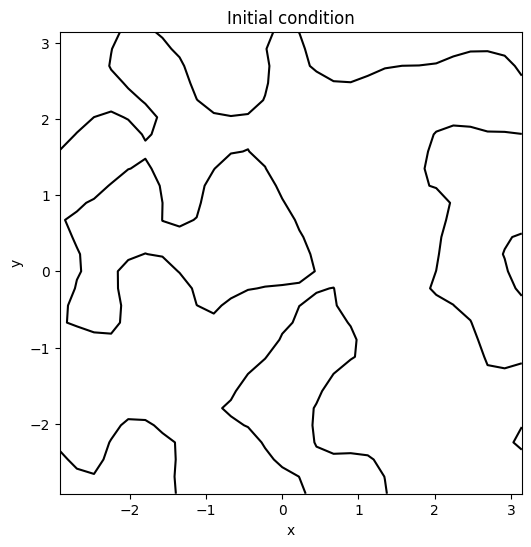

real space u ko size =(10000, 28, 28, 1)
s_hat ko size = (10000, 28, 28, 1)
inverse u ko size = (10000, 28, 28, 1)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (10000, 28, 28, 28)
inverse u ko size = (10000, 28, 28, 28)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (10000, 28, 28, 28)
inverse u ko size = (10000, 28, 28, 28)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (10000, 28, 28, 28)
inverse u ko size = (10000, 28, 28, 28)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (10000, 28, 28, 28)
inverse u ko size = (10000, 28, 28, 28)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (10000, 28, 28, 28)
inverse u ko size = (10000, 28, 28, 28)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (10000, 28, 28, 28)
inverse u ko size = (10000, 28, 28, 28)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (10000, 28, 28, 28)
inverse u ko size = (10000, 28, 28, 28)
real space u ko size =(10000, 28, 28, 28)
s_hat ko size = (

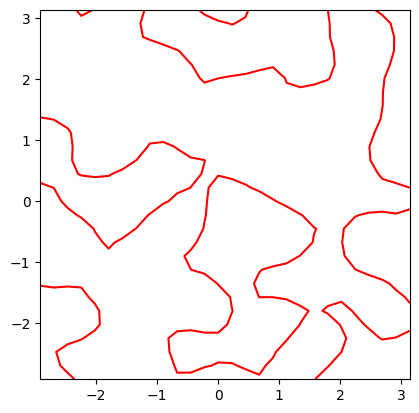

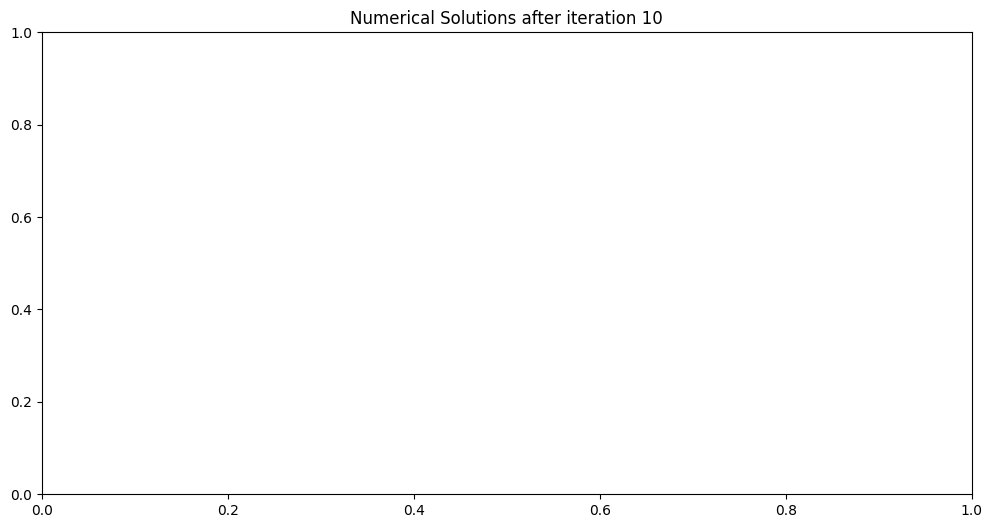

Initial and final conditions saved as:
- 'initial_condition.npy' and 'initial_condition.txt'
- 'final_output.npy' and 'final_output.txt'
Current u_iter shape: (10000, 28, 28, 28)
Plotting value: (28, 28, 28, 10000)


In [30]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# Parameters
N = 28 # no. of grid points
# eps = 0.05 # epsillon 
# lr = 0.001 # learning rate
T = 1
dt = 0.1 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots



x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


# theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation_checking/phasefield_data_28x28_Onet_10k.npy')
print(f"Training data shape: {input_condition.shape}")

 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction



# # difinning the no of grid points in x, y and z
# Nx = 28 # number of grid points in x be positive even integer number
# Ny = 28 # number of grid points in y be positive even integer number

# # Define the parameters of the Allen-Cahn equation in 2d
# Lx = 2.0 * jnp.pi #length of the domain in x
# Ly = 2.0 * jnp.pi #length of the domain in y
# hx = Lx / Nx #spatial step size in coordinate x
# hy = Ly / Ny #spatial step size in coordinate y
# dt = 0.0001 #time step size
# T = 4 #final time
# Nt = int(jnp.round(T/dt)) #number of time steps
# ns = Nt / 10 #number of snapshots

# # Define the grid points in x and y direction
# def x_gridpoint(Nx, Lx, hx):
#     x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
#     return x
# x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
# def y_gridpoint(Ny, Ly, hy):
#     y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
#     return y
# y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# # creating meshgrid in x and y direction
# xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
#It determines the scale of the transition region (interface width) between phases. its the width of the interface, smaller epsillon refer to the sharp transition

epsillon = 0.05 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
# uk =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# theta = jnp.arctan(y/x)
# u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))
uk = np.load('data_generation_checking/phasefield_data_28x28_Onet_10k.npy')

# # defining the wavenumber in x and y direction , which is in fourier space
# p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
# q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# # square of wavenumber in x and y direction
# p2 = p**2 # square of wavenumber in x direction
# q2 = q**2 # square of wavenumber in y direction

# # creating meshgrid in x and y direction for square of wavenumber
# pp2, qq2 = jnp.meshgrid(p2, q2)
#print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # plotting the initial condition of the Allen-Cahn equation


#this figure code is pervious code 
figure1 = plt.figure()
plt.figure(figsize = (12, 6))
plt.contour(x, y, jnp.real(uk[0,:,:,0].T), levels = [0], colors = 'black')
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# # providing the range of iteration

for iter in range(1, Nt):
    u = jnp.real(uk)
    print(f'real space u ko size ={u.shape}')
    # Transforming the solution to the discrete Fourier space
    s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u)) # us is the real space
    print(f's_hat ko size = {s_hat.shape}')
    v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
    uk = jfft.ifft2(v_hat)  # u_k+1 result
    print(f'inverse u ko size = {u.shape}')

    if iter == 1:
        plt.contour(x, y, jnp.real(uk[0,:,:,0]), levels =[0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')
        
    # if iter == 4000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='green' )
    #     plt.gca().set_aspect('equal', adjustable='box')
    
    # if iter == 10000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='blue')
    #     plt.gca().set_aspect('equal', adjustable='box')

    # if iter == 20000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
    #     plt.gca().set_aspect('equal', adjustable='box')
    

    # if iter % ns == 0:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
    #     plt.gca().set_aspect('equal', adjustable='box') 
    #     # np.save("initial_condition.npy", uk)
    #     # np.save("final_output.npy", jnp.real(u))


# from this line to the print initial and final condition saved as for data saved purpose
# Save the final output
  # Save in .txt format (readable)
plt.figure(figsize = (12, 6))
plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()


# # this is previous code   
# plt.title('Numerical Solutions after iteration ' + str(Nt))
# plt.show()

# Notify user of saved files
print("Initial and final conditions saved as:")
print("- 'initial_condition.npy' and 'initial_condition.txt'")
print("- 'final_output.npy' and 'final_output.txt'")
print(f"Current u_iter shape: {u.shape}")
print(f"Plotting value: {jnp.real(uk.T).shape}")


## caluated accuracy togrther with loss

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u


from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error


class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    def allen_cahn_equation(self, uk, total_steps=500):
      

            # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1)) 
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1)) 
    

        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  
        

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        v_hat = s_hat / denominator  
        uk = jfft.ifft2(v_hat)  
        uk = uk.reshape(self.N, self.N, 1)
     
        return jnp.real(uk) # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
        u_ac = self.allen_cahn_equation(uk)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
       
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, data_train, data_test, nIter=10000):
        data = iter(data_train)
        pbar = trange(nIter)  # Progress bar for total iterations


        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss_train = self.loss_batches(params, batch)
                loss_test = self.loss_batches(params, data_test)
                self.train_losses.append(loss_train)
                self.test_losses.append(loss_test)
                pbar.set_postfix({'train Loss': loss_train, 'test loss': loss_test})

    def accuracy(self, data_test):
        uk_ac_list = []
        uk_nn_list = []


        pp2 = jnp.expand_dims(pp2, axis=(0, -1)) 
        qq2 = jnp.expand_dims(qq2, axis=(0, -1))  
        

        for iteam in data_test:

            uk_ac = self.allen_cahn_equation(uk)
           

            uk_nn = NN_model.operator_net(params, iteam[0])
            uk_nn_list.append(uk_nn)
        uk_ac = jnp.array(uk_ac_list)
        uk_nn = jnp.array(uk_nn_list)

        u_pred = jnp.reshape(uk_nn, (uk_nn.shape[0], -1 ))  
        u_true = jnp.reshape(uk_ac, (uk_ac.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, u_true



    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            print(f'train_loss shape {total_train_loss.shape},test_loss shape {total_test_loss.shape}')
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 30000

data = np.load('data_generation_checking/phasefield_data_28x28_denormalized_10k.npy')
normalized_data, min_val, range_val = normalize(data) 
# Generate the data trainig samples
data_train = DataGenerator(data[:9800], batch_size=20)
data_test = data[9800:9900]
# data_test = DataGenerator(data[2000:2050], batch_size = 50)
# print(f'data_trian shape:{data_train[0].shape}, data_test shape:{data_test[0].shape}')



#    # Initialize and train the model
NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
NN_model.train(data_train, data_test, nIter = epochs)
# NN_model.test(data_test)

NN_model.plot_losses('plots/')







            

## to see the plotting

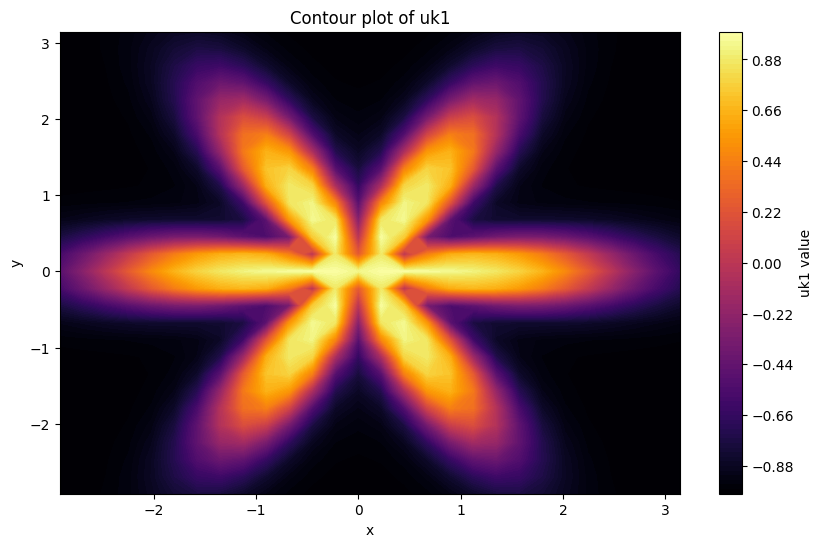

In [20]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Define the grid
# Parameters
N = 28 # no. of grid points
eps = 0.6 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2*jnp.pi # length of domian
h = L/N 
# x = np.linspace(-10, 10, 400)
# y = np.linspace(-10, 10, 400)

x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = np.meshgrid(x, y)

# Define theta and eps
theta = jnp.arctan2(yy, xx)
  # or another appropriate value
uk1_values = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * eps))
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, uk1_values, levels=100, cmap='inferno')
plt.colorbar(label='uk1 value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of uk1')
plt.show()


# checking the allen cahn function right or not 

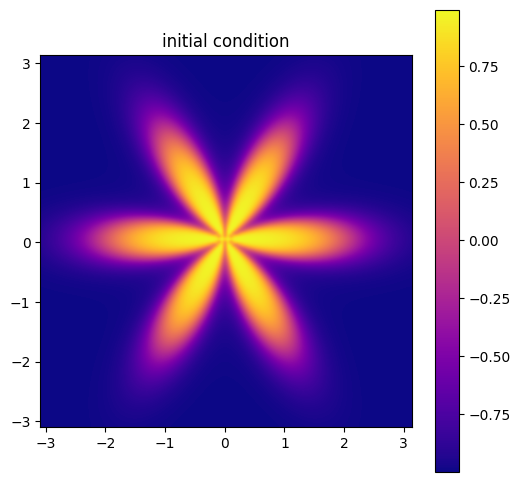

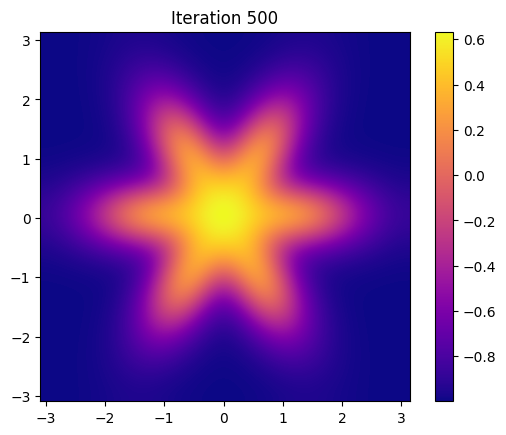

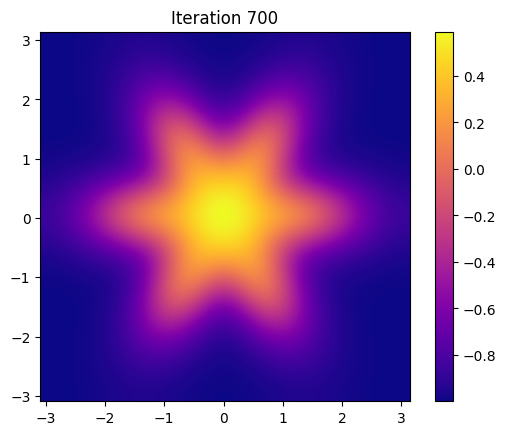

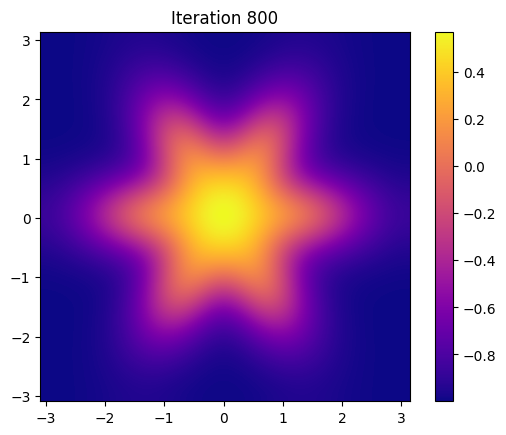

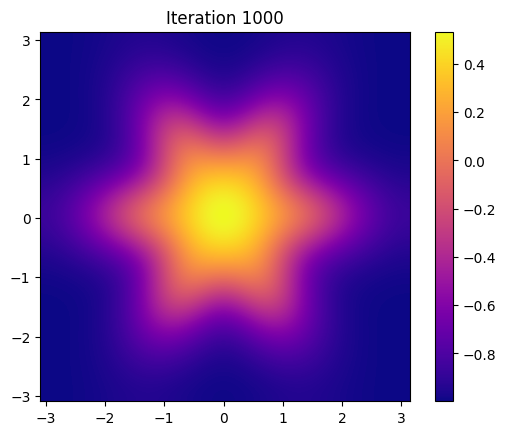

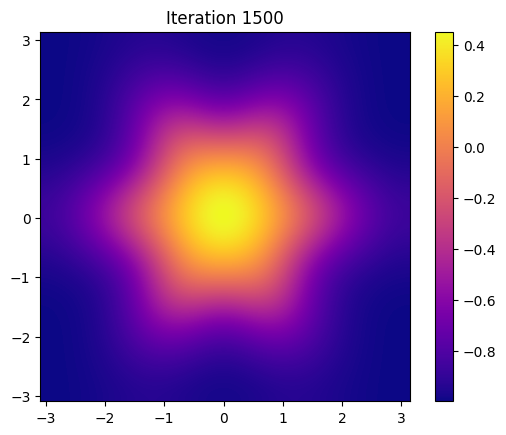

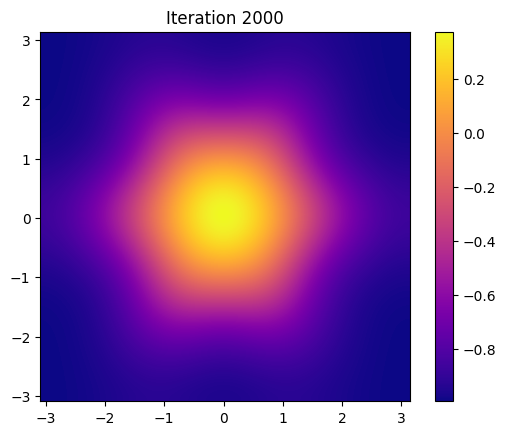

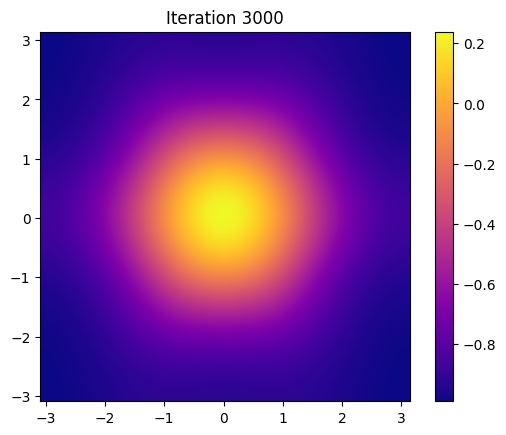

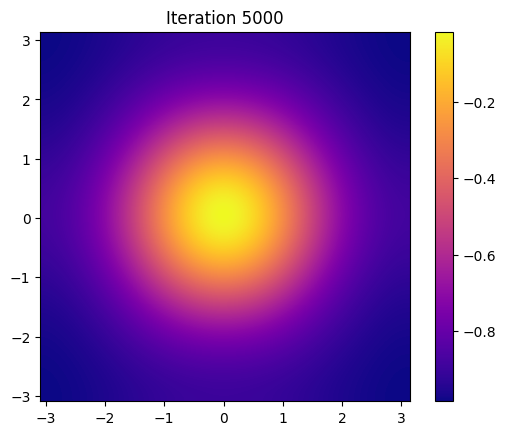

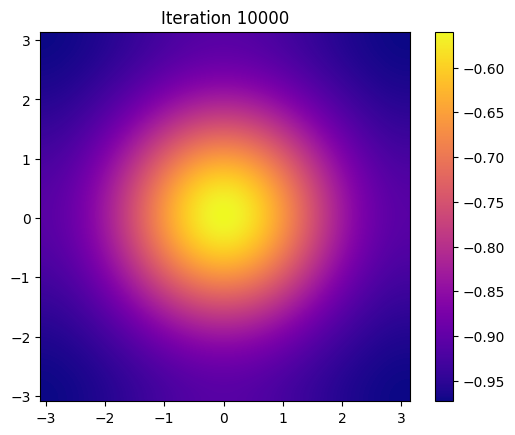

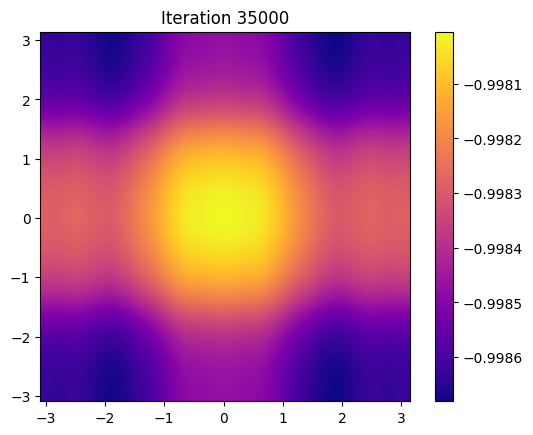

In [6]:

import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter


# @partial(jit, static_argnums=(0,))
def allen_cahn_equation(uk):
    eps = 1.0
    cahn = eps**2
    uk = jnp.real(uk)

    # Compute denominator in Fourier space
    denominator = cahn + dt * (2 + cahn * (pp2 + qq2))
    # print("Denominator shape:", denominator.shape)

    # Expand the denominator to match the shape of s_hat (28, 28, 1)
    # denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
    # print("Denominator shape after expansion:", denominator.shape)

    # Perform FFT calculations
    s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 
    # print("Shape of s_hat (after fft2):", s_hat.shape)

    v_hat = s_hat / denominator  # Now shapes should match
    # print("Shape of v_hat (after division):", v_hat.shape)

    uk = jfft.ifft2(v_hat)  # inverse FFT
    # print("Shape of uk (after ifft2):", uk.shape)

    # uk = uk.reshape(N, N, 1)  # Reshaping to (N, N, 1)
    # print("Shape of uk after reshaping:", uk.shape)

    # Return the real part
    return jnp.real(uk)  # Return only the real part


# def plot_fig()


# difinning the no of grid points in x, y and z
Nx = 128 # number of grid points in x be positive even integer number
Ny = 128 # number of grid points in y be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
#It determines the scale of the transition region (interface width) between phases. its the width of the interface, smaller epsillon refer to the sharp transition

epsillon = 0.5 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
# uk =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# Define theta and eps
theta = jnp.arctan2(yy, xx)
  # or another appropriate value
uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * epsillon))
# theta = jnp.arctan(y/x)
# u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))


# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
#print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # plotting the initial condition of the Allen-Cahn equation


#this figure code is pervious code 
figure1 = plt.figure(figsize = (6, 6))
# plt.contour(x, y, jnp.real(uk.T), [0], colors = 'black')
# plt.imshow(jnp.real(uk))
# plt.gca().set_aspect('equal', adjustable='box') 
# plt.title('Initial condition')
# # plt.xlabel('x')
# # plt.ylabel('y')
# # plt.show()

# plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

#         # Overlay contours
# # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

# plt.gca().set_aspect("equal", adjustable="box")
# # plt.colorbar(label="Value")  # Optional colorbar
# plt.title(f"Iteration {iter}")

plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()],cmap='plasma', interpolation='bicubic')
plt.title(f"initial condition")
plt.colorbar()
plt.show()



# # providing the range of iteration

for iter in range(1, Nt):
   

    uk = allen_cahn_equation(uk)
    # print(f'uk ko shape: {uk.shape}')

    if iter == 500:
        # # plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        # plt.imshow(jnp.real(uk))
        # plt.gca().set_aspect('equal', adjustable='box')

        # # Display the image
        # plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

        # # Overlay contours
        # # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

        # plt.gca().set_aspect("equal", adjustable="box")
        # # plt.colorbar(label="Value")  # Optional colorbar
        # plt.title(f"Iteration {iter}")

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

        
                
    if iter == 700:
        # # plt.contour(x, y, jnp.real(uk.T), [0], colors='green' )
        # plt.imshow(jnp.real(uk))
        # plt.gca().set_aspect('equal', adjustable='box')

        # plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

        # # Overlay contours
        # # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

        # plt.gca().set_aspect("equal", adjustable="box")
        # # plt.colorbar(label="Value")  # Optional colorbar
        # plt.title(f"Iteration {iter}")

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    
    if iter == 800:
        # plt.contour(x, y, jnp.real(uk.T), [0], colors='blue')
        # plt.imshow(jnp.real(uk))
        # plt.gca().set_aspect('equal', adjustable='box')
        # plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

        # Overlay contours
        # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

        # plt.gca().set_aspect("equal", adjustable="box")
        # plt.colorbar(label="Value")  # Optional colorbar
        # plt.title(f"Iteration {iter}")

        # plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

        # # Overlay contours
        # # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

        # plt.gca().set_aspect("equal", adjustable="box")
        # # plt.colorbar(label="Value")  # Optional colorbar
        # plt.title(f"Iteration {iter}")

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()



    # plt.savefig(f'figs/allen_cahn_pre_{iter}.png', bbox_inches='tight', pad_inches=0)

    # plt.show()
    if iter == 1000:
        # plt.contour(x, y, jnp.real(uk.T), [0], colors='yellow')
        # plt.imshow(jnp.real(uk))
        # plt.gca().set_aspect('equal', adjustable='box')
        # # plt.title('solver_28x28_iteration ' + str(iter))
        # # plt.imshow(jnp.real(uk))
        # # plt.gca().set_aspect('equal', adjustable='box')
        # # plt.axis('off')

        # plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

        # # Overlay contours
        # # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

        # plt.gca().set_aspect("equal", adjustable="box")
        # # plt.colorbar(label="Value")  # Optional colorbar
        # plt.title(f"Iteration {iter}")

        plt.imshow(jnp.real(uk),extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

        
        # break
    if iter == 1500:
        # plt.contour(x, y, jnp.real(uk.T), [0], colors='pink')
        # plt.imshow(jnp.real(uk))
        # plt.gca().set_aspect('equal', adjustable='box')
        # plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

        # # Overlay contours
        # # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

        # plt.gca().set_aspect("equal", adjustable="box")
        # # plt.colorbar(label="Value")  # Optional colorbar
        # plt.title(f"Iteration {iter}")

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()


    if iter == 2000:
        # plt.contour(x, y, jnp.real(uk.T), [0], colors='purple')
        # plt.imshow(jnp.real(uk))
        # plt.gca().set_aspect('equal', adjustable='box')

        # plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], origin="lower", cmap="coolwarm", alpha=0.8)

        # # Overlay contours
        # # plt.contour(X, Y, jnp.real(uk), levels=10, colors="black")  # Adjust levels for more/fewer lines

        # plt.gca().set_aspect("equal", adjustable="box")
        # # plt.colorbar(label="Value")  # Optional colorbar
        # plt.title(f"Iteration {iter}")


        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 3000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 5000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 10000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 35000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()


# plt.show()








In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import imageio

# Folder where images are saved
folder = "figs"

# Get the list of image files
image_files = sorted([f for f in os.listdir(folder) if f.endswith(".png")], 
                     key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Read in the images
frames = []
for filename in image_files:
    img = imageio.imread(os.path.join(folder, filename))
    frames.append(img)

# Set a shorter duration (in seconds) per frame. Lower value = faster animation.
# For example, duration=0.02 gives 50 frames per second.
gif_path = 'animation/allen_cahn_animation_28x28_2000_new.gif'
os.makedirs("animation", exist_ok=True)
imageio.mimsave(gif_path, frames, duration=0.0002)

print("GIF created with imageio at a faster speed.")

# # Create figure
# fig, ax = plt.subplots()

# # Load first image as a placeholder
# first_image = plt.imread(os.path.join(folder, image_files[0]))
# plt.axis('off')
# im = ax.imshow(first_image)

# def update(frame):
#     img = plt.imread(os.path.join(folder, image_files[frame]))
#     im.set_array(img)
#     return im,

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_files), interval=50, blit=True)

# # Save animation (Optional: MP4 or GIF)
# ani.save('animation/allen_cahn_animation_28x28_2000.gif', writer='pillow', fps=200)  # For GIF
# # ani.save('allen_cahn_animation.mp4', writer='ffmpeg', fps=2)  # For MP4


# # Delete all .png images in the folder after saving the animation
# # for img_file in image_files:
# #     os.remove(os.path.join(folder, img_file))

# print("Animation saved and all figure files deleted.")

# # Show animation
# plt.show()


C:\Users\Manju\AppData\Local\Temp\ipykernel_31360\202926850.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(folder, filename))


GIF created with imageio at a faster speed.


In [ ]:
import cv2
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Simulation parameters
Nx, Ny = 128, 128  # grid dimensions

Lx = 2.0 * jnp.pi
Ly = 2.0 * jnp.pi
hx = Lx / Nx
hy = Ly / Ny
dt = 0.0001
T = 4
Nt = int(jnp.round(T / dt))

# Define grid points
def x_gridpoint(Nx, Lx, hx):
    return jnp.linspace(-0.5 * Lx + hx, 0.5 * Lx, Nx)
x = x_gridpoint(Nx, Lx, hx)

def y_gridpoint(Ny, Ly, hy):
    return jnp.linspace(-0.5 * Ly + hy, 0.5 * Ly, Ny)
y = y_gridpoint(Ny, Ly, hy)

# Create meshgrid
xx, yy = jnp.meshgrid(x, y)

# Allen-Cahn parameters and initial condition
epsillon = 0.5
cahn = epsillon**2
uk = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / (jnp.sqrt(2) * epsillon))

# Dummy Allen-Cahn update function for demonstration
def allen_cahn_equation(u):
    return u + 0.001 * jnp.sin(jnp.linspace(0, 2*jnp.pi, u.size).reshape(u.shape))

# Video parameters
frame_width, frame_height = 28, 28  # in pixels
fps = 120
output_file = "animation/output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Create a Matplotlib figure
dpi = 300  # Increased DPI for better text visibility
fig_inches = (frame_width / dpi, frame_height / dpi)
fig = plt.figure(figsize=fig_inches, dpi=dpi)

# Create an axes that fills the entire figure
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')  # remove axes borders/ticks

canvas = FigureCanvas(fig)

for iter in range(1, Nt):
    
    
    # Update the simulation
    uk = allen_cahn_equation(uk)
    
    # Clear the axes for the new frame
    ax.clear()
    ax.set_axis_off()
    
    # Plot the image
    im = ax.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
    ax.set_title(f'Iteration {iter}')
    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # plt.show()
    # ax.imshow(jnp.real(uk),
            #   extent=[float(x.min()), float(x.max()), float(y.min()), float(y.max())],
            #   cmap='plasma', interpolation='bicubic')
    
    # Add text (iteration number) at the top center
    # ax.text(0.5, 0.9, f"Iteration {i}", 
    #         color='white', fontsize=2.5, ha='center', va='center', transform=ax.transAxes)

    # Draw the canvas and convert to a NumPy array
    canvas.draw()
    frame = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(canvas.get_width_height()[::-1] + (3,))
    
    # Convert RGB (Matplotlib) to BGR (OpenCV)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # Write the frame to the video
    video_writer.write(frame_bgr)

    if iter % 2000 == 0:
        print(f'Frame {iter} is starting')
        break

video_writer.release()
print("Video saved successfully!")


C:\Users\Manju\AppData\Local\Temp\ipykernel_10272\3310415819.py:82: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


KeyboardInterrupt: 

In [36]:
from moviepy import ImageSequenceClip
import os

folder = "figs"
image_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".png")],
                     key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Create a video clip with 1000 frames per second (adjust as needed)
clip = ImageSequenceClip(image_files, fps=100)
os.makedirs("animation", exist_ok=True)
clip.write_videofile("animation/allen_cahn_animation_28x28_2000_100fps.mp4", codec="libx264")


MoviePy - Building video animation/allen_cahn_animation_28x28_2000_100fps.mp4.
MoviePy - Writing video animation/allen_cahn_animation_28x28_2000_100fps.mp4



MoviePy - Done !
MoviePy - video ready animation/allen_cahn_animation_28x28_2000_100fps.mp4
